In [1]:
from __future__ import annotations

from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt

from core import cat_aligner, utils

from PIL import ImageOps, Image
import IPython.display


In [2]:
out_folder = Path("/tmp/temp_cats")
aligner = cat_aligner.CatAlignerEyes
n_samples = 10_000

all_files = utils.Paths.list_sorted_files()
files = all_files[:n_samples]
names = [f.image.stem[4:] for f in files]


In [3]:
arr = utils.parse_image(files[0].image)
print(arr.shape)
print(arr[:, :, 0])

(500, 375, 3)
[[115 115 121 ... 138 137 137]
 [116 107 115 ... 138 138 137]
 [117 108 101 ... 137 136 136]
 ...
 [119 130 118 ...  45  37  39]
 [ 94  95  92 ...  52  51  53]
 [ 93  70  81 ...  56  56  60]]


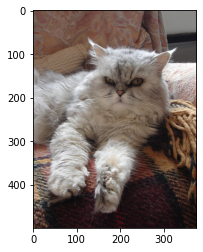

In [4]:
plt.imshow(arr)

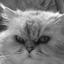

In [5]:
images = [ImageOps.grayscale(aligner.align_one_image(f, 64, 64)) for f in files]
shape = np.array(images[0]).shape
images[0]

In [6]:
X_train = np.array([np.array(im).flatten() for im in images])
X_train

array([[ 87,  89,  92, ..., 120, 109, 114],
       [  0,   0,   0, ...,  24,  22,  25],
       [136, 114, 107, ..., 169, 170, 178],
       ...,
       [151, 154, 110, ...,  56,  28,   6],
       [  0,   0,   0, ..., 137, 128,  90],
       [ 72,  76, 109, ..., 190, 193, 191]], dtype=uint8)

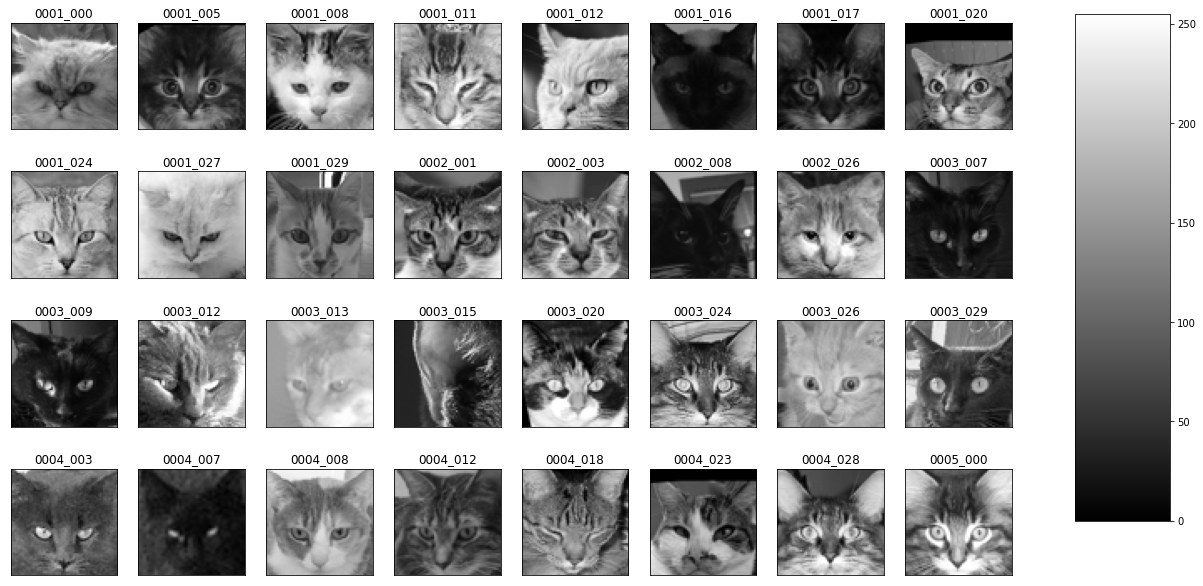

In [7]:
utils.plot_portraits(X_train, shape, 4, 8, titles=names, vmax=255, vmin=0, colorbar=True)

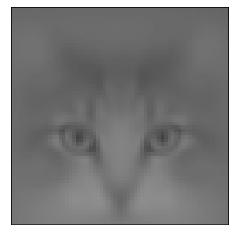

In [8]:
X_mean = X_train.mean(axis=0)
utils.plot_image(X_mean, shape=shape, vmax=255, vmin=0)

In [9]:
def dilate_components(arr: np.ndarray) -> np.ndarray:
    return arr - arr.min()

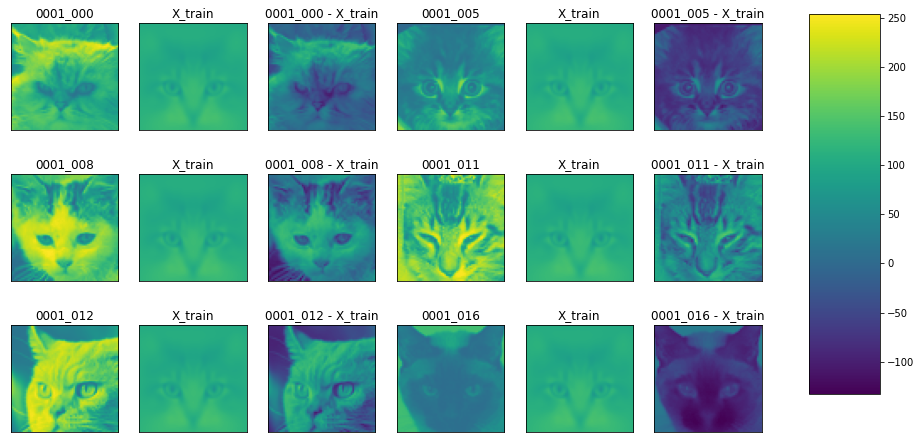

In [10]:
portraits, titles = [], []
for i in range(6):
    portraits.extend([X_train[i], X_mean, X_train[i] - X_mean])
    titles.extend([names[i], 'X_train', f'{names[i]} - X_train'])

portraits = np.array(portraits)
vmax, vmin = portraits.max(), portraits.min()
utils.plot_portraits(portraits, shape, 3, 6, titles=titles, vmax=vmax, vmin=vmin, cmap='viridis',colorbar=True)

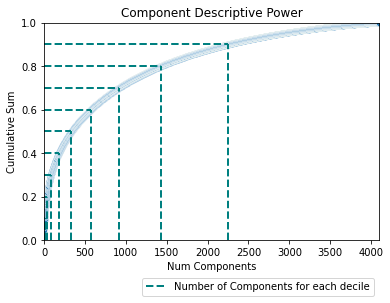

In [11]:
U, S, Vt = np.linalg.svd(X_train - X_mean, full_matrices=False)

utils.plot_principle_components(S)



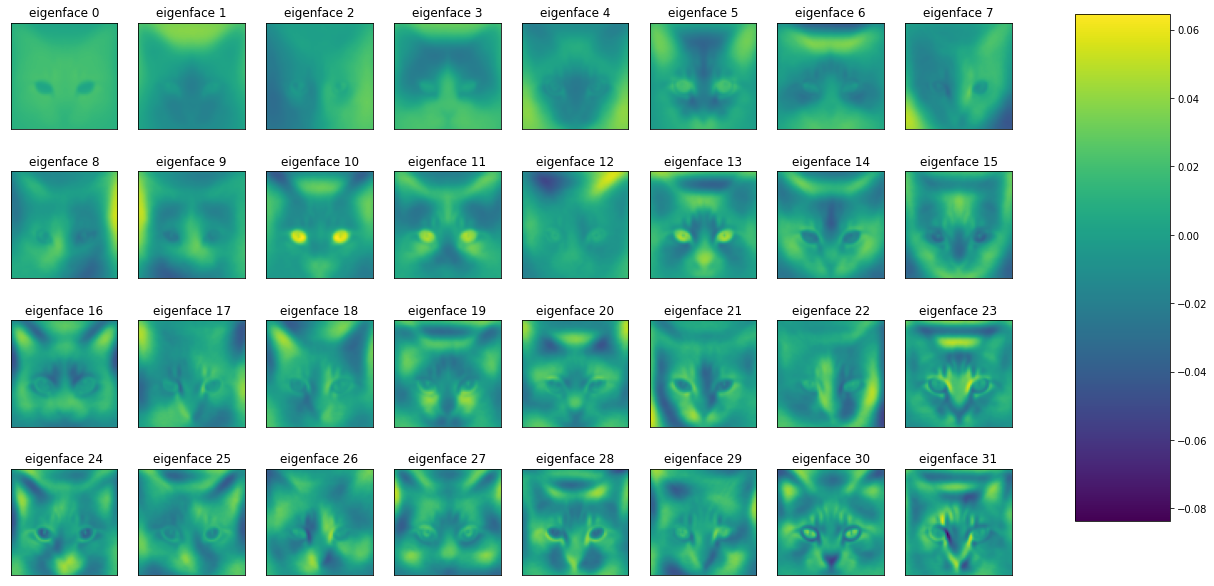

In [12]:
eigenfaces = Vt[:32]
eigenface_titles = [f"eigenface {i}" for i in range(32)]
utils.plot_portraits(Vt, shape, 4, 8, eigenface_titles, vmin=eigenfaces.min(), vmax=eigenfaces.max(), colorbar=True, cmap='viridis')

In [22]:
def reconstruct_with_components(
    image: int | slice | list[int], component: int | slice
):
    principle_compoents = U[image, component] * S[component]
    principle_directions = Vt[component]

    return (principle_compoents @ principle_directions) + X_mean
out_folder.mkdir(exist_ok=True)
gif_folder = out_folder / "gif_subimages"

gif_folder.mkdir(exist_ok=True)

S_cum = S.cumsum() / S.sum()

percentiles = [0, 1]
for x in np.arange(0, 1, 0.02):
    idx = np.searchsorted(S_cum, x)
    if idx > percentiles[-1]:
        percentiles.append(idx)

for n_components in percentiles:

    X_final = reconstruct_with_components(slice(32), slice(n_components))
    fig = utils.plot_portraits(
        X_final, shape, 4, 8, titles=names, suptitle=f"{n_components} Components", vmin=0, vmax=255, colorbar=True
    )
    out_folder.mkdir(exist_ok=True)
    fig.savefig(gif_folder / f"{n_components}_components.png")



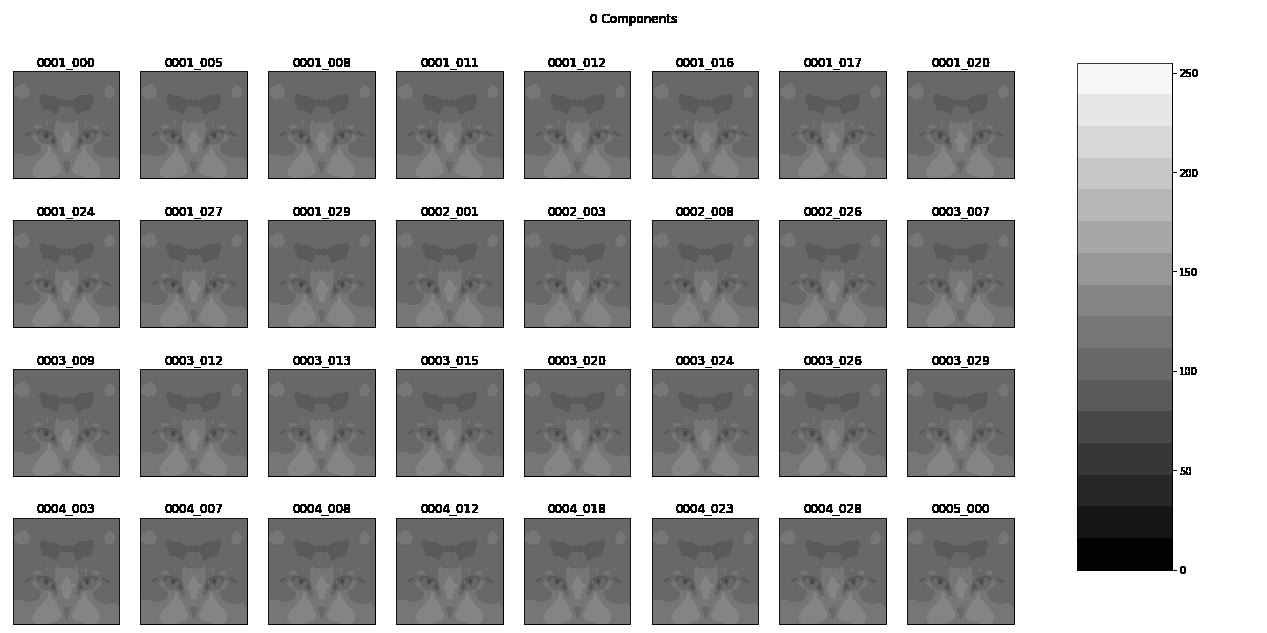

In [24]:
def save_gif(*, outpath: Path, subimage_dir: Path) -> Path:
    def key(path: Path) -> int:
        return int(path.stem[: path.stem.find("_")])

    files = sorted(subimage_dir.iterdir(), key=key)
    img, *imgs = [Image.open(f) for f in files]

    img.save(
        fp=outpath,
        format="GIF",
        append_images=imgs,
        save_all=True,
        duration=200,
        loop=0,
    )

    return outpath
    
gif_path = save_gif(outpath=out_folder / "iterative_components.gif", subimage_dir=gif_folder)

IPython.display.Image(gif_path)

In [17]:
Vt.shape, U.shape, S.shape

((4096, 4096), (9997, 4096), (4096,))

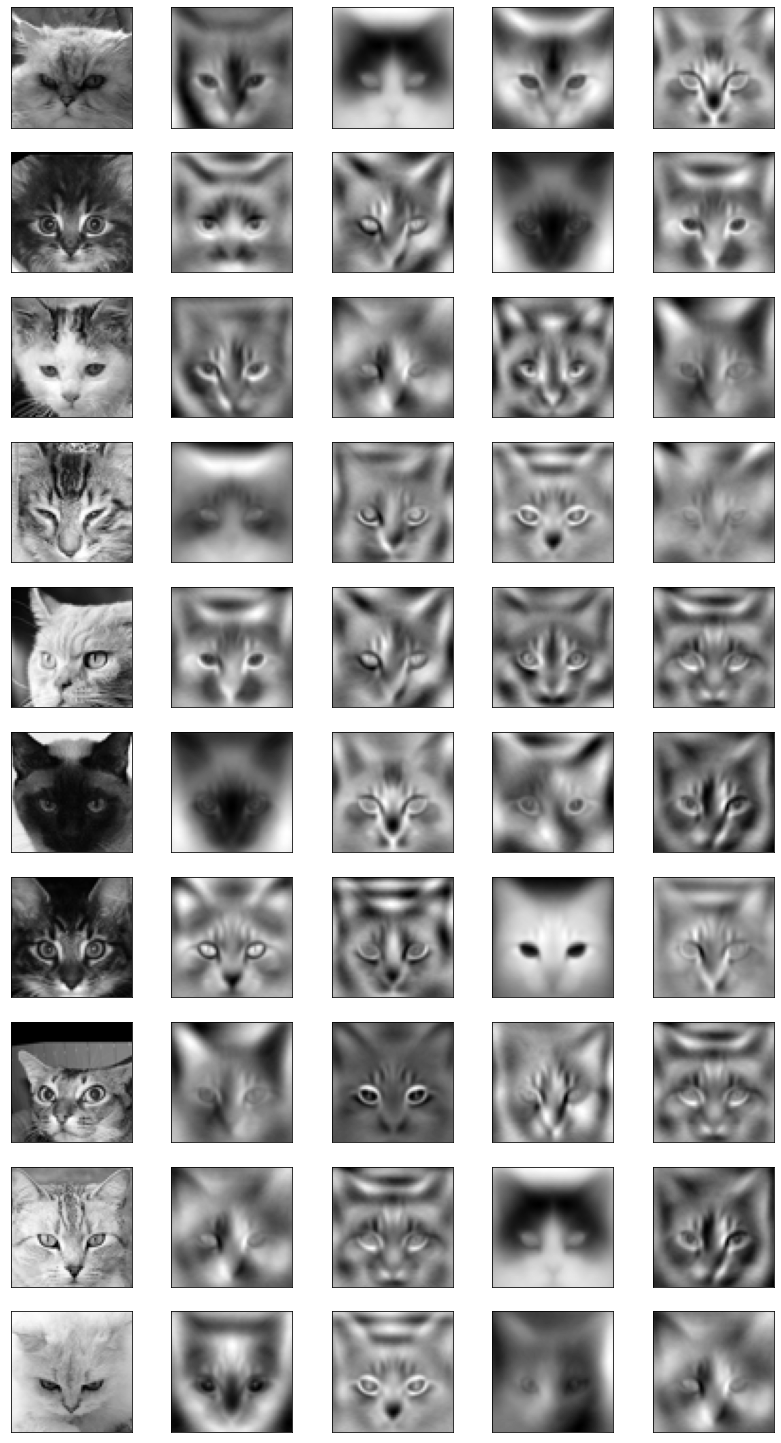

In [21]:
import seaborn as sns
portraits = []
for i in range(10):
    y = np.abs((U * S) @ Vt.T)[i, :50]
    portraits.extend([X_train[i], *Vt[(len(y) - y.argsort()).argsort()][:4]])
utils.plot_portraits(portraits, shape=shape, n_row=10, n_col=5)
# sns.scatterplot(y=np.abs(Vt.T @ (U * S))[18], x=range(100))
# len(portraits)